# Predicting customer churn (attrition)

### By: Raphael Rivers

# Model Predictions, Performance and Cross-Validation

The model prediction will use `Model 8` and `Model 5`, which appear to be the best models on the training set. To perform prediction we will create a new dataset and classify them.

In [1]:
# Import all modules and read in dataset
from modules import*

In [2]:
# retrive models and numeric clusters
%store -r formula_list
%store -r fit_df

In [3]:
# Make deep copy
df_copy = fit_df

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_copy, columns=['state', 'area_code', 'international_plan', 'voice_mail_plan'], drop_first=True)

# Display the first few rows of the encoded dataframe
df_encoded.head()


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,False,False,False,False,False,False,True,False,False,True
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,False,False,False,False,False,False,True,False,False,True
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,False,False,False,False,False,False,True,False,False,False
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,False,False,False,False,False,False,False,False,True,False
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,False,False,False,False,False,False,True,False,True,False


In [4]:
# Define coeficient CI plot
def coefplot(model, figsize_use=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize_use)
    
    ax.errorbar( y=model.params.index,
                 x=model.params,
                 xerr = 2 * model.bse,
                 fmt='v', color='b', ecolor='b', elinewidth=2, ms=10)
    
    ax.axvline(x=0, linestyle='--', linewidth=3.5, color='grey')
    
    ax.set_xlabel('Coefficient Value')
    
    plt.show()

In [5]:
# Check Model 8 fomula
formula_list[-1]

'churn ~ pca_cluster * (total_day_minutes + total_eve_minutes + total_night_minutes + total_intl_minutes + np.power(total_day_minutes, 2) + np.power(total_eve_minutes, 2) + np.power(total_night_minutes, 2) + np.power(total_intl_minutes, 2))'

In [6]:
# Fit model 8
model_8 = smf.logit(formula=formula_list[-1], data=fit_df).fit()

Optimization terminated successfully.
         Current function value: 0.353014
         Iterations 7


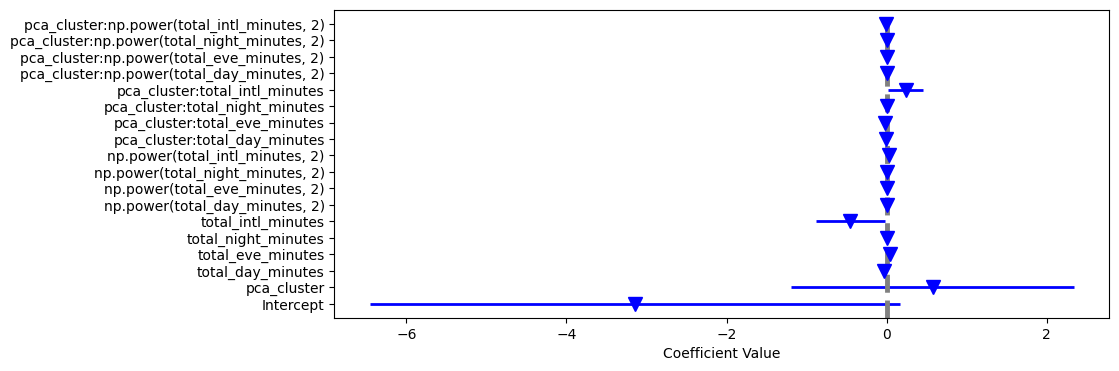

In [7]:
coefplot(model_8)

In [8]:
# Check Model 5 formula
formula_list[5]

'churn ~ (total_day_minutes + total_eve_minutes + total_night_minutes + total_intl_minutes) ** 2'

In [9]:
# Fit model 5
model_5 = smf.logit(formula=formula_list[5], data=fit_df).fit()

Optimization terminated successfully.
         Current function value: 0.363993
         Iterations 7


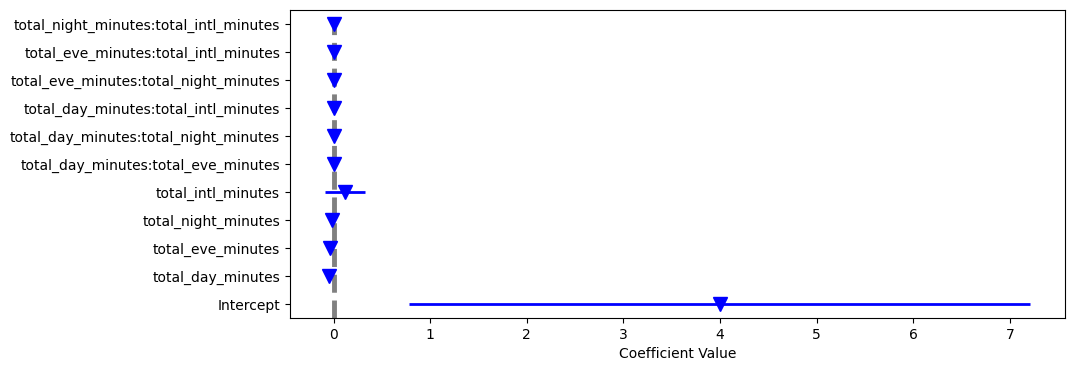

In [10]:
coefplot(model_5)

### Create the Input Grid

In [11]:
# Continuous input for grid with 101 unique values
continuous_input = 'total_day_minutes'
min_value = df_encoded[continuous_input].min()
max_value = df_encoded[continuous_input].max()
grid_values = np.linspace(min_value, max_value, 101)

In [12]:
# Other two important inputs
other_input1 = 'pca_cluster'
other_input2 = 'total_eve_minutes'

In [13]:
# Unique values for other inputs
unique_values_1 = df_encoded[other_input1].unique()
unique_values_2 = np.linspace(df_encoded[other_input2].min(), df_encoded[other_input2].max(), 5)

In [14]:
# Set constant values for remaining inputs
constant_values = df_encoded.median()
constant_values[other_input1] = df_encoded[other_input1].mode()[0]

In [15]:
# Create the input grid dataframe
input_grid = pd.DataFrame({
    continuous_input: np.tile(grid_values, len(unique_values_1)),
    other_input1: np.repeat(unique_values_1, 101),
    other_input2: constant_values[other_input2]
})

In [16]:
# Set constant values for remaining inputs
for col in df_encoded.columns:
    if col not in input_grid.columns:
        input_grid[col] = constant_values[col]

In [17]:
# Display the input grid
input_grid.head()

,total_day_minutes,pca_cluster,total_eve_minutes,account_length,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_minutes,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,0.000,1,201.0,100.0,0.0,100.0,30.62,100.0,17.09,200.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.515,1,201.0,100.0,0.0,100.0,30.62,100.0,17.09,200.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.030,1,201.0,100.0,0.0,100.0,30.62,100.0,17.09,200.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.545,1,201.0,100.0,0.0,100.0,30.62,100.0,17.09,200.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.060,1,201.0,100.0,0.0,100.0,30.62,100.0,17.09,200.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Define formulas for Models 4 and 8 using encoded data
formula_5 = 'churn ~ pca_cluster * (total_day_minutes + total_eve_minutes + total_night_minutes + total_intl_minutes)'
formula_8 = 'churn ~ pca_cluster * (total_day_minutes + total_eve_minutes + total_night_minutes + total_intl_minutes + np.power(total_day_minutes, 2) + np.power(total_eve_minutes, 2) + np.power(total_night_minutes, 2) + np.power(total_intl_minutes, 2))'

# Fit Models 5 and 8
model_5 = smf.logit(formula=formula_5, data=df_encoded).fit(disp=False)
model_8 = smf.logit(formula=formula_8, data=df_encoded).fit(disp=False)

# Make predictions for Models 5 and 8
input_grid['pred_5'] = model_5.predict(input_grid)
input_grid['pred_8'] = model_8.predict(input_grid)

# Display the input grid with predictions
input_grid[['total_day_minutes', 'pca_cluster', 'pred_5', 'pred_8']].head()

,total_day_minutes,pca_cluster,pred_5,pred_8
0,0.000,1,0.013969,0.510622
1,3.515,1,0.014561,0.478349
2,7.030,1,0.015178,0.447038
3,10.545,1,0.015820,0.416913
4,14.060,1,0.016489,0.388147


### Visualize the Predictions

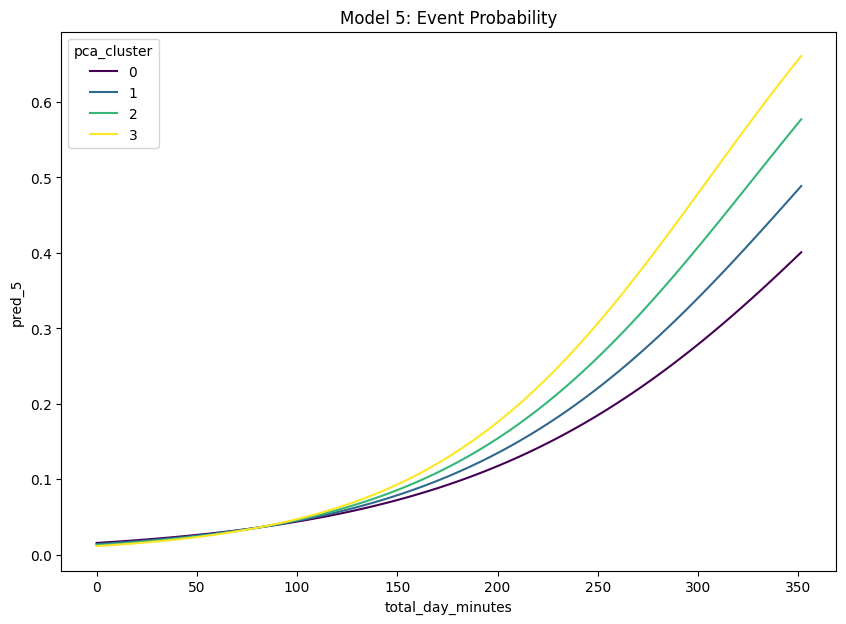

In [19]:
# Plot predictions for Model 5
plt.figure(figsize=(10, 7))
sns.lineplot(data=input_grid, x='total_day_minutes', y='pred_5', hue='pca_cluster', palette='viridis')
plt.title('Model 5: Event Probability')
plt.show()

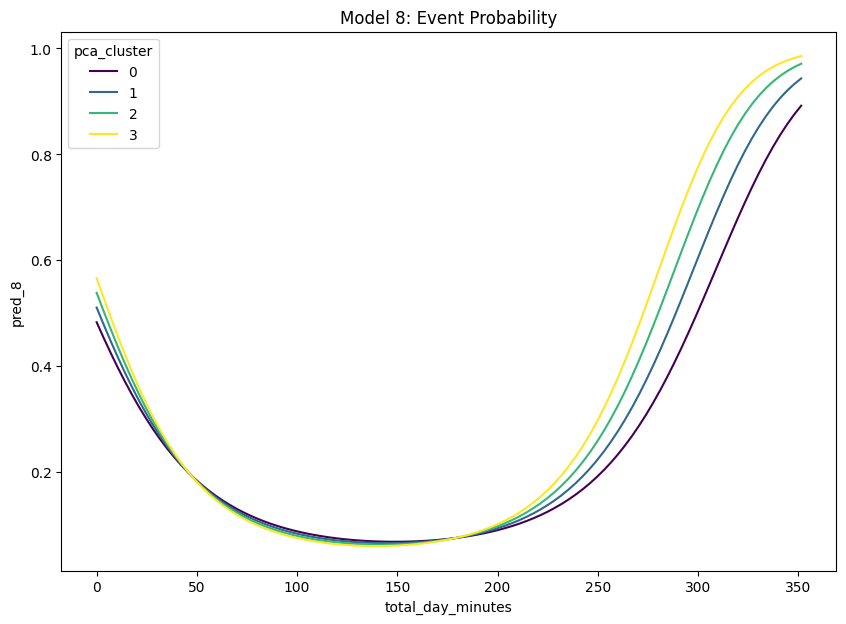

In [20]:
# Plot predictions for Model 8
plt.figure(figsize=(10, 7))
sns.lineplot(data=input_grid, x='total_day_minutes', y='pred_8', hue='pca_cluster', palette='viridis')
plt.title('Model 8: Event Probability')
plt.show()


### Prediction Summary
The prediction results for Models 5 and 8, visualized in the plots, indicate how the event probability (churn) varies with `total_day_minutes`, differentiated by the pca_cluster categories. In both models, the probability of `churn` generally increases as the `total_day_minutes` increases, but the rate of increase varies across different clusters. 
Specifically, certain clusters exhibit a sharper rise in churn probability with increasing `total_day_minutes`, suggesting that these groups are more sensitive to higher usage. Model 8, which includes interaction terms and polynomial features, shows more nuanced trends with slight fluctuations in the churn probability, indicating a more complex relationship between the features. This suggests that while both models capture the general trend of increasing churn with usage, Model 8 provides a more detailed and potentially more accurate representation of the underlying patterns, especially for different customer segments defined by the PCA clusters.

## Performance and Validation

In [21]:
# Import modules
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

In [22]:
# Define function to evaluate model using cross-validation
def evaluate_model_cv(formula, data, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    auc_scores = []
    
    for train_index, test_index in skf.split(data, data['churn']):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        model = smf.logit(formula=formula, data=train_data).fit(disp=False)
        predictions = model.predict(test_data)
        
        auc = roc_auc_score(test_data['churn'], predictions)
        auc_scores.append(auc)
    
    return auc_scores

In [23]:
# Evaluate Models 5 and 8 using cross-validation
auc_scores_5 = evaluate_model_cv(formula_list[5], fit_df)
auc_scores_8 = evaluate_model_cv(formula_list[8], fit_df)

In [24]:
# Calculate The model 5 mean and 95% confidence interval for ROC AUC scores
mean_auc_5 = np.mean(auc_scores_5)
std_auc_5 = np.std(auc_scores_5)
ci_5 = 1.96 * std_auc_5 / np.sqrt(len(auc_scores_5))

In [25]:
# Calculate The model 8 mean and 95% confidence interval for ROC AUC scores
mean_auc_8 = np.mean(auc_scores_8)
std_auc_8 = np.std(auc_scores_8)
ci_8 = 1.96 * std_auc_8 / np.sqrt(len(auc_scores_8))

In [26]:
# Display the validation results
validation_results_df = pd.DataFrame({
    'Model': ['Model 5', 'Model 8'],
    'Mean ROC AUC': [mean_auc_5, mean_auc_8],
    '95% CI': [ci_5, ci_8]
})
validation_results_df

,Model,Mean ROC AUC,95% CI
0,Model 5,0.670502,0.017519
1,Model 8,0.679838,0.011672


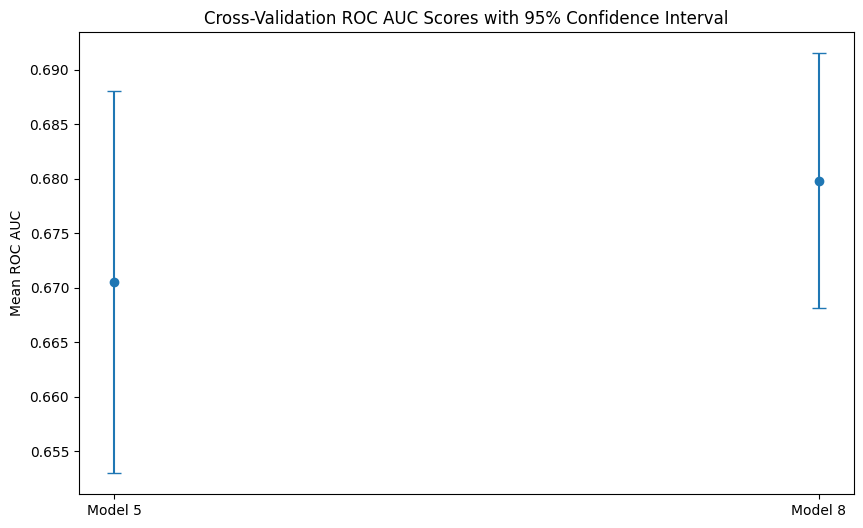

In [27]:
#Visualize the results
# Visualize the results
plt.figure(figsize=(10, 6))
plt.errorbar(x=['Model 5', 'Model 8'], y=[mean_auc_5, mean_auc_8], yerr=[ci_5, ci_8], fmt='o', capsize=5)
plt.title('Cross-Validation ROC AUC Scores with 95% Confidence Interval')
plt.ylabel('Mean ROC AUC')
plt.show()

### Model preformance validation interpretation

From the best-fit model performance validation results and visualization, we can see that the Mean ROC AUC for `Model 5` has a mean ROC AUC score of 0.6705 and `Model 8` has a mean ROC AUC score of 0.6798. This ROC_AUC score indicates the model's ability to distinguish between the positive class (churn) and the negative class (no churn). Higher values indicate better performance. `Model 8` has a slightly higher ROC_AUC score compared to Model_5, indicating better performance in distinguishing between churn and non-churn customers. And this is consistent across the board. 

How confident are we with these results? The 95% Confidence Interval reveals that a 0.0175 estimate for `Model 5` and 0.0117 for `Model 8`. Overall the 95% confidence interval gives an estimate of the uncertainty around the mean ROC_AUC score. The smaller CI indicates a more reliable and stable performance as seen with `Model 8`. Model 8 not only has a higher mean ROC AUC score but also a smaller confidence interval compared to Model 4, indicating more consistent performance across different folds.

### Insight From Analysis

This provides several key insights into the customer data, which can be crucial for understanding customer behavior and making strategic decisions. 

1. Customer Segments:

- Cluster 0: This cluster might represent customers with moderate usage across all services. Their account length, day, evening, and night call minutes and charges are all around average compared to other clusters.
- Cluster 1: Customers in this cluster tend to have lower total minutes and charges across different time periods. They might be light users with minimal interaction with the service.
- Cluster 2: This cluster likely includes heavy users, as indicated by higher total day, evening, and night minutes and corresponding charges. These customers might be more valuable but also more demanding in terms of service.
- Cluster 3: Similar to Cluster 2 but with slightly different usage patterns, possibly indicating a different type of high-usage behavior, such as more international calls or higher customer service interactions.

2. Usage Patterns:

- Total Minutes and Charges: Clusters reveal distinct patterns in the total minutes and charges. Heavy users (Cluster 2 and Cluster 3) show significantly higher values, indicating a strong relationship between usage and charges.
- Voicemail and Customer Service Calls: The log-transformed variables for voicemail messages and customer service calls show varying concentrations across clusters. For instance, a higher number of customer service calls in Cluster 3 might indicate dissatisfaction or complex service needs.

3. Impact of International and Voice Mail Plans:

- Clusters can help identify the impact of having an international plan or a voice mail plan. For example, if one cluster shows significantly higher usage and charges for international calls, it can inform the marketing team to target similar users with international plans.

4. Service Needs and Customer Behavior:

- Customer Service Calls: The clusters help in identifying which segments are more likely to interact with customer service frequently. This can be critical for improving customer satisfaction and reducing churn.
- Voicemail Usage: Identifying clusters with higher voicemail usage can help tailor communication and feature offerings to enhance user experience.

5. Strategic Implications:

- Targeted Marketing: By understanding the distinct clusters, marketing efforts can be more targeted, focusing on high-value customers or those needing specific services.
- Service Improvements: Recognizing clusters with higher customer service interactions can lead to targeted improvements in service quality and support.
- Churn Prediction: Clusters with high usage but also high customer service calls might be at higher risk of churn. This insight can be used to develop retention strategies.

6. Dimensionality Reduction Effectiveness:

- The PCA transformation effectively reduced the data's dimensionality while preserving the variance, making it easier to visualize and interpret the clusters.

Overall, the PCA-based clustering revealed significant insights into customer behavior, usage patterns, and service needs. These insights can guide targeted marketing, service improvements, and strategic decisions to enhance customer satisfaction and retention. The clusters provide a clear segmentation of customers, helping to tailor strategies for different segments effectively.